# FastVision.ai

### Initial Data pass through & EDA: Luna16 dataset

#### Link to the dataset: https://web.archive.org/web/20190522064041/https://luna16.grand-challenge.org/data/



### Part 1: Initial Data pass-through

**Disclaimer**: Part 1 of this notebook is based on Sentdex's video walkthrough of his modeling approach using Tensorflow described in this series: https://www.youtube.com/watch?v=KlffppN47lc&list=PLQVvvaa0QuDd5meH8cStO9cMi98tPT12_&t=11s

My attempt is using the same approach with `PyTorch`

In [7]:
import os
import glob
import copy
import time

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from collections import namedtuple


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [6]:
#!pip install torchvision 

     ---------------------------------------- 1.2/1.2 MB 6.9 MB/s eta 0:00:00
     ------------------------------------- 172.4/172.4 MB 11.7 MB/s eta 0:00:00


#### SimpleITK

SimpleITK provides functions to read and write .mhd files (file type in Luna16 dataset), allowing you to import medical image data into your Python environment and perform various image processing tasks on them. 

In [2]:
#!pip install SimpleITK

     --------------------------------------- 27.0/27.0 MB 15.6 MB/s eta 0:00:00


In [8]:
import SimpleITK as sitk

#### Let's look at Annotations file that contains the center and diameter of each mass in CT scans

In [11]:
df_annotations = pd.read_csv('./data/luna16/annotations.csv')
df_annotations.head()

seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150

In [122]:
df_annotations.shape

(1186, 5)

There are total **1186** annotations in the dataset

#### Candidate file overview: 
- The candidates file contains a `class` flag for each mass in the CT scans.

- `seriesuid` is the unique identifer of the CT scan.

- `coordX`, `coordY` and `coordZ` are coorindates of the center of the mass.

- `class` is 0 if the mass isn't a nodule, and 1 if it is a nodule (both malignant and benign).

In [16]:
df_candidates = pd.read_csv('./data/luna16/candidates_V2/candidates_V2.csv')
df_candidates.head()

seriesuid     coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  68.420000  -74.480000   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -95.209361  -91.809406   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -24.766755 -120.379294   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -63.080000  -65.740000   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  52.946688  -92.688873   

       coordZ  class  
0 -288.700000      0  
1 -377.426350      0  
2 -273.361539      0  
3 -344.240000      0  
4 -241.067872      0

In [17]:
df_candidates.shape

(754975, 5)

In [18]:
print(f'Total annotations: {df_annotations.shape[0]}, Unique CT scans: {len(df_annotations.seriesuid.unique())}')
print(f'Total candidates: {df_candidates.shape[0]}, Unique CT scans: {len(df_candidates.seriesuid.unique())}')

Total annotations: 1186, Unique CT scans: 601
Total candidates: 754975, Unique CT scans: 888


#### Values above show that there are multiple annotations available for single CT scans in the dataset.

Let's group all annotations that are part of same CT scan based on `seriesuid`:

In [19]:
diameters = {}

for _, row in df_annotations.iterrows():    
    
    center_xyz = (row.coordX, row.coordY, row.coordZ)   
    
    diameters.setdefault(row.seriesuid, []).append(
        (center_xyz, row.diameter_mm)
    )

In [20]:
%%time

CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    ['is_nodule', 'diameter_mm', 'series_uid', 'center_xyz']
)

# list to store all candidates in the dataset
candidates = []

for _, row in df_candidates.iterrows():    
    
    candidate_center_xyz = (row.coordX, row.coordY, row.coordZ)
    
    candidate_diameter = 0.0    
    
    for annotation in diameters.get(row.seriesuid, []):        
        
        annotation_center_xyz, annotation_diameter = annotation        
        
        for i in range(3):            
            
            delta = abs(candidate_center_xyz[i] - annotation_center_xyz[i])            
            
            if delta > annotation_diameter / 4:
                    break            
        
        else:
            candidate_diameter = annotation_diameter            
            
            break
            
            
    
    candidates.append(CandidateInfoTuple(
        bool(row['class']),
        candidate_diameter,
        row.seriesuid,
        candidate_center_xyz
    ))

CPU times: total: 28.5 s
Wall time: 59.8 s


In [21]:
candidates.sort(reverse=True)

### Missing data

There are some `seriesuid` in dataset that do not have corresponding CT scans associated to them. Let's find out:

In [23]:
%%time

from concurrent.futures import ThreadPoolExecutor

def find_missing_and_multiple(startidx, endidx):
    
    missing_cts = []
    multiple_cts = []
    
    for c in tqdm(candidates[startidx: endidx]):
        filepaths = glob.glob(f'./data/luna16/subset*/*/{c.series_uid}.mhd')
        if len(filepaths) == 0:
            missing_cts.append(c.series_uid)
        elif len(filepaths) > 1:
            multiple_cts.append(c.series_uid)
    
    return missing_cts, multiple_cts


all_missing = []
all_multiple = []

with ThreadPoolExecutor() as executor:

    total = len(candidates)
    middle = total // 2
    quarter = middle // 2
    
    startidx = [0, quarter, middle, middle + quarter]
    endidx = [quarter, middle, middle + quarter, total]
    
    for res in executor.map(find_missing_and_multiple, startidx, endidx):
        all_missing += res[0]
        all_multiple += res[1]

missing_uids = {uid for uid in all_missing}

  0%|          | 0/188743 [00:00<?, ?it/s]

  0%|          | 0/188744 [00:00<?, ?it/s]

  0%|          | 0/188745 [00:00<?, ?it/s]

  0%|          | 0/188743 [00:00<?, ?it/s]

CPU times: total: 1min 16s
Wall time: 5min 55s


In [24]:
candidates_clean = list(filter(lambda x: x.series_uid not in missing_uids, candidates))

print(f'All candidates in dataset: {len(candidates)}')
print(f'Candidates with CT scan  : {len(candidates_clean)}')

All candidates in dataset: 754975
Candidates with CT scan  : 377138


In [25]:
candidate = candidates_clean[0]

candidate

CandidateInfoTuple(is_nodule=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(66.58022805, 82.56931698, -110.5421104))

**I'm using `glob` module to find the `.mhd` and `.raw` files associated with each candidate. The files could be in any one of the subset folders in the dataset.** 

**The `glob` module allows us to find the file by using patterns instead of manually looking inside each of the folders.**

In [27]:
# Look for the file `<series_uid>.mhd` inside the `subset` folders
filepaths = glob.glob(f'./data/luna16/subset*/*/{candidate.series_uid}.mhd')

# We removed all candidates that don't have corresponding CT scan files
# This line is another fail-safe to know when a CT scan doesn't exist
assert len(filepaths) != 0, f'CT scan with seriesuid {candidate.series_uid} not found!'

filepaths

['./data/luna16\\subset1\\subset1\\1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd']

In [28]:
mhd_file_path = filepaths[0]

mhd_file_path

'./data/luna16\\subset1\\subset1\\1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd'

#### loading `.mhd` file with the help of `SimpleITK` package

In [29]:
mhd_file = sitk.ReadImage(mhd_file_path)

**Reading CT scan file and storing it as `NumPy` array**

In [30]:
ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)

In [31]:
ct_scan.clip(-1000, 1000, ct_scan)

array([[[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-10

#### Voxel size definition:

*In the context of medical imaging, voxel size refers to the physical size of a single voxel in a three-dimensional image. Voxel is short for "volume element" and represents a discrete three-dimensional pixel within an image volume*

In [32]:
origin_xyz = mhd_file.GetOrigin()
voxel_size_xyz = mhd_file.GetSpacing()
direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)

#### Converting to `NumPy` arrays:

In [33]:
origin_xyz_np = np.array(origin_xyz)
voxel_size_xyz_np = np.array(voxel_size_xyz)

In [34]:
cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np

# Since we'll be using column, row and index values to index into arrays, we round them to the nearest integer.
cri = np.round(cri)

# we need the scan to be in the order index, row, column
irc = (int(cri[2]), int(cri[1]), int(cri[0]))

In [35]:
ct_scan.shape

(123, 512, 512)

#### `ct_scan` shape indicates each CT scan is very large with 512 x 512 resolution for a single CT scan.

To mitigate the size issue, we will extract the information we need from single scan by slicing each scan in three slices, one for each direction X, Y and Z. Code implementation below:

In [36]:
dims_irc = (10, 18, 18)

In [37]:
# We will create three slices - one for each direction, used to extract a region of interest from the CT scan
slice_list = []

for axis, center_val in enumerate(irc):
    
    
    start_index = int(round(center_val - dims_irc[axis]/2))
    end_index = int(start_index + dims_irc[axis])

    
    if start_index < 0:
        start_index = 0
        end_index = int(dims_irc[axis])
    
    
    if end_index > ct_scan.shape[axis]:
        end_index = ct_scan.shape[axis]
        start_index = int(ct_scan.shape[axis] - dims_irc[axis])
        
    slice_list.append(slice(start_index, end_index))
    
tuple(slice_list)

(slice(68, 78, None), slice(288, 306, None), slice(223, 241, None))

In [38]:
ct_scan_chunk = ct_scan[tuple(slice_list)]
ct_scan_chunk.shape

(10, 18, 18)

**Converting CT scan chnunk to `PyTorch` tensor for modeling input**

In [39]:
# Create a tensor from the NumPy array of the CT scan chunk
ct_scan_chunk_tensor = torch.from_numpy(ct_scan_chunk)

# convert it to a tensor of float32
ct_scan_chunk_tensor = ct_scan_chunk_tensor.to(torch.float32)
    
# Add an extra dimension to represent a single channel in the 3d image
ct_scan_chunk_tensor = ct_scan_chunk_tensor.unsqueeze(0)

ct_scan_chunk_tensor.shape

torch.Size([1, 10, 18, 18])

In [40]:
candidate.is_nodule

True

In [41]:
torch.tensor([
    not candidate.is_nodule,
    candidate.is_nodule,
], dtype=torch.long)

tensor([0, 1])

#### Setting up utility functions important for training

In [42]:
#!pip install diskcache cassandra-driver

     ---------------------------------------- 45.6/45.6 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 2.9/2.9 MB 17.0 MB/s eta 0:00:00


In [50]:
# The code in this cell is from the Deep Learning with PyTorch book's GitHub repository
# https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/util/disk.py


import gzip

from cassandra.cqltypes import BytesType
from diskcache import FanoutCache, Disk, core
from diskcache.core import io, MODE_BINARY
from io import BytesIO

class GzipDisk(Disk):
    def store(self, value, read, key=None):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param value: value to convert
        :param bool read: True when value is file-like object
        :return: (size, mode, filename, value) tuple for Cache table
        """
        # pylint: disable=unidiomatic-typecheck
        if type(value) is BytesType:
            if read:
                value = value.read()
                read = False

            str_io = BytesIO()
            gz_file = gzip.GzipFile(mode='wb', compresslevel=1, fileobj=str_io)

            for offset in range(0, len(value), 2**30):
                gz_file.write(value[offset:offset+2**30])
            gz_file.close()

            value = str_io.getvalue()

        return super(GzipDisk, self).store(value, read)


    def fetch(self, mode, filename, value, read):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param int mode: value mode raw, binary, text, or pickle
        :param str filename: filename of corresponding value
        :param value: database value
        :param bool read: when True, return an open file handle
        :return: corresponding Python value
        """
        value = super(GzipDisk, self).fetch(mode, filename, value, read)

        if mode == MODE_BINARY:
            str_io = BytesIO(value)
            gz_file = gzip.GzipFile(mode='rb', fileobj=str_io)
            read_csio = BytesIO()

            while True:
                uncompressed_data = gz_file.read(2**30)
                if uncompressed_data:
                    read_csio.write(uncompressed_data)
                else:
                    break

            value = read_csio.getvalue()

        return value

def getCache(scope_str):
    return FanoutCache('data-unversioned/cache/' + scope_str,
                       disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       )

raw_cache = getCache('ct_scan_raw')

@raw_cache.memoize(typed=True)
def getCtScanChunk(series_uid, center_xyz, dims_irc):

        filepaths = glob.glob(f'./data/luna16/subset*/*/{series_uid}.mhd')
        assert len(filepaths) != 0, f'CT scan with seriesuid {series_uid} not found!'
        mhd_file_path = filepaths[0]
        
        mhd_file = sitk.ReadImage(mhd_file_path)
        ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
        ct_scan.clip(-1000, 1000, ct_scan)
        
        origin_xyz = mhd_file.GetOrigin()
        voxel_size_xyz = mhd_file.GetSpacing()
        direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)
        
        origin_xyz_np = np.array(origin_xyz)
        voxel_size_xyz_np = np.array(voxel_size_xyz)
        
        cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np
        cri = np.round(cri)
        irc = (int(cri[2]), int(cri[1]), int(cri[0]))
        
        slice_list = []
        for axis, center_val in enumerate(irc):
            
            start_index = int(round(center_val - dims_irc[axis]/2))
            end_index = int(start_index + dims_irc[axis])
            
            if start_index < 0:
                start_index = 0
                end_index = int(dims_irc[axis])
                
            if end_index > ct_scan.shape[axis]:
                end_index = ct_scan.shape[axis]
                start_index = int(ct_scan.shape[axis] - dims_irc[axis])

            slice_list.append(slice(start_index, end_index))
            
        ct_scan_chunk = ct_scan[tuple(slice_list)]
        
        return ct_scan_chunk

In [51]:
class LunaDataset(Dataset):
    
    def __init__(self, is_validation_set=False, validation_stride=0):
        '''Create a PyTorch dataset for the CT scans
        
        If `is_validation_set` is `True` then every `validation_stride` item is kept.
        Otherwise, every `validation_stride` item is deleted
        '''
        
        # Make a copy of all the candidates.
        # Pick every 350th candidate so that we have about 1k candidates in the dataset
        # It takes agonizingly long to load more data!
        self.candidates = copy.copy(candidates_clean[::350])
        
        # If this is the validation set, keep every `validation_stride` item
        if is_validation_set:
            self.candidates = self.candidates[::validation_stride]
        
        # If this is the training set, delete every `validation_stride` item
        else:
            del self.candidates[::validation_stride]
            
    def __len__(self):
        '''Returns the number of items in the dataset'''
        return len(self.candidates)
    
    def __getitem__(self, i):
        '''Get the `i`the item in the dataset'''
        
        # Get the `i`th candidate
        candidate = self.candidates[i]
        
        # We want to resize each CT scan to the following dimensions
        dims_irc = (10, 18, 18)
        
        # Use the utility function to fetch the CT scan
        ct_scan_np = getCtScanChunk(candidate.series_uid, candidate.center_xyz, dims_irc)
        
        # Convert the CT scan to a tensor
        ct_scan_tensor = torch.from_numpy(ct_scan_np).to(torch.float32).unsqueeze(0)
        
        # Convert the target to a tensor
        label_tensor = torch.tensor([
            not candidate.is_nodule,
            candidate.is_nodule
        ], dtype=torch.long)
        
        return ct_scan_tensor, label_tensor

#### Creating `DataLoader` from our dataset.

Using `VALIDATION_STRIDE` equal to 10, i.e. every 10th CT scan will be in the validation set

In [52]:
VALIDATION_STRIDE=10
BS=16

train_ds = LunaDataset(is_validation_set=False, validation_stride=VALIDATION_STRIDE)
val_ds = LunaDataset(is_validation_set=True, validation_stride=VALIDATION_STRIDE)

train_dl = DataLoader(train_ds, batch_size=BS, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=BS, num_workers=0)

In [53]:
def train_loop(model, dataloader, criterion, optimizer, ds_size):
    '''Train the model for one epoch'''
    
    # Put the model in training mode to activate dropout
    model.train()
    
    # Keep a track of the loss and correct predictions for the epoch
    running_loss = 0.0
    running_corrects = 0
    
    # Track the total number of positives and true positives
    running_pos = 0
    running_pos_correct = 0
    
    # Track the total number of negatives and true negatives
    running_neg = 0
    running_neg_correct = 0
    
    for inputs, labels in tqdm(dataloader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # --- Standard PyTorch training process ---
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels[:,1])
        loss.backward()
        
        optimizer.step()
        # -----------------------------------------
        
        # Calculate loss and correct predictions in batch
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data[:,1])
        
        # Calculate positives and true positives in batch
        running_pos += labels.data[:,1].sum()
        running_pos_correct += ((preds == labels.data[:,1]) & (labels.data[:,1] == 1)).sum()
        
        # Calculate negatives and true negatives in batch
        running_neg += labels.data[:,0].sum()
        running_neg_correct += ((preds == labels.data[:,1]) & (labels.data[:,1] == 0)).sum()

    epoch_loss = running_loss / ds_size
    epoch_acc = running_corrects.double() / ds_size
    
    return epoch_loss, epoch_acc, (running_pos_correct, running_pos), (running_neg_correct, running_neg)
    
    

def eval_loop(model, dataloader, criterion, ds_size):
    '''Evaluate the model performance for one epoch'''

    # Put the model in evaluation mode to deactivate dropout
    model.eval()

    # Keep track of loss, predictions, and other numbers we are interested in
    # just like in the training loop
    running_loss = 0.0
    running_corrects = 0
    
    running_pos = 0
    running_pos_correct = 0
    running_neg = 0
    running_neg_correct = 0
    
    # Don't calculate gradients
    with torch.no_grad():
    
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels[:,1])
        
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data[:,1])
            
            running_pos += labels.data[:,1].sum()
            running_pos_correct += ((preds == labels.data[:,1]) & (labels.data[:,1] == 1)).sum()

            running_neg += labels.data[:,0].sum()
            running_neg_correct += ((preds == labels.data[:,1]) & (labels.data[:,1] == 0)).sum()
        
    epoch_loss = running_loss / ds_size
    epoch_acc = running_corrects.double() / ds_size
    
    return epoch_loss, epoch_acc, (running_pos_correct, running_pos), (running_neg_correct, running_neg)

### Model Training

In [54]:
class LunaModel(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool3d(2)
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool3d(2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(2048, 1024)
        self.relu3 = nn.ReLU()
        
        self.dropout = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(1024, 2)
    
    def forward(self, X):
        
        # Dimensions of X => [BS, 1, 10, 18, 18]
        
        X = self.maxpool1(self.relu1(self.conv1(X)))
        X = self.maxpool2(self.relu2(self.conv2(X)))
        
        X = self.flatten(X)

        X = self.relu3(self.fc1(X))
        X = self.dropout(X)
        
        return self.fc2(X)

In [55]:
# Create an instance of the model
model = LunaModel()

# Use the GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Use the cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Use the AdamW optimizer
optimizer = optim.AdamW(model.parameters(), weight_decay=0.1)

In [56]:
EPOCHS = 5

for epoch in range(EPOCHS):

    epoch_start = time.time()

    train_loss, train_acc, train_pos, train_neg = train_loop(
        model, train_dl, criterion,
        optimizer, len(train_ds)
    )

    val_loss, val_acc, val_pos, val_neg = eval_loop(
        model, val_dl, criterion, len(val_ds)
    )

    time_elapsed = time.time() - epoch_start
    print(f'Epoch: {epoch+1:02} | Epoch Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print()
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tTrain - correct pos: {train_pos[0]}/{train_pos[1]} | correct neg: {train_neg[0]}/{train_neg[1]}')
    print()
    print(f'\tVal. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    print(f'\tVal. - correct pos: {val_pos[0]}/{val_pos[1]} | correct neg: {val_neg[0]}/{val_neg[1]}')
    print()


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 9m 28s

	Train Loss: 0.382 | Train Acc: 98.97%
	Train - correct pos: 1/2 | correct neg: 959/968

	Val. Loss: 67.984 |  Val. Acc: 99.07%
	Val. - correct pos: 0/1 | correct neg: 107/107



  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s

	Train Loss: 144.434 | Train Acc: 98.25%
	Train - correct pos: 0/2 | correct neg: 953/968

	Val. Loss: 19.698 |  Val. Acc: 99.07%
	Val. - correct pos: 0/1 | correct neg: 107/107



  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 3s

	Train Loss: 28.077 | Train Acc: 99.79%
	Train - correct pos: 0/2 | correct neg: 968/968

	Val. Loss: 1.888 |  Val. Acc: 99.07%
	Val. - correct pos: 0/1 | correct neg: 107/107



  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s

	Train Loss: 0.245 | Train Acc: 99.79%
	Train - correct pos: 0/2 | correct neg: 968/968

	Val. Loss: 2.499 |  Val. Acc: 99.07%
	Val. - correct pos: 0/1 | correct neg: 107/107



  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 3s

	Train Loss: 0.098 | Train Acc: 99.79%
	Train - correct pos: 0/2 | correct neg: 968/968

	Val. Loss: 2.541 |  Val. Acc: 99.07%
	Val. - correct pos: 0/1 | correct neg: 107/107



### Key Findings:

- We've got an accuracy of over 99% on the validation set

- However, the numbers below the accuracy give us a clearer picture of what is going on. The model predicted all negatives correctly, but didn't make any correct predictions for the positive data points.

- Possibly an indication that we do not have enough positive samples in the training and validation set. 

- Dataset appears to be highly imbalanced.

In [123]:
#!pip install pydicom

In [63]:
#!pip install generators

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for generators: filename=generators-2020.4.27-py3-none-any.whl size=42881 sha256=6a7ea91f178afb78b3f26473704c34572e635efcaaeb070792ae5d0ce80b277e
  Stored in directory: c:\users\uzair\appdata\local\pip\cache\wheels\a5\cd\1e\e1e4592e2c32a27972a20e424fd96148c2123b1639a97e7c1f
  Created wheel for strict_functions: filename=strict_functions-2020.2.4-py3-none-any.whl size=15477 sha256=98863fcac89ea25fc53dc55a3ec6aedd0e22781a16e81ed453eac2100d9a5a00
  Stored in directory: c:\users\uzair\appdata\local\pip\cache\wheels\08\d8\1c\5e03d4271d09191ab616fd6e16cec0f278eb5c32b02c76f252
Successfully built generators strict_functions


## Part 2: EDA

In [76]:
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
import numpy as np


print(os.listdir("./data/luna16"))

['annotations.csv', 'candidates.csv', 'candidates_V2', 'evaluationScript', 'sampleSubmission.csv', 'seg-lungs-LUNA16', 'subset0', 'subset1', 'subset2', 'subset3', 'subset4']


In [80]:
if os.path.isfile("./data/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd"):
    print("File exists")
else:
    print("File does not exist")

File exists


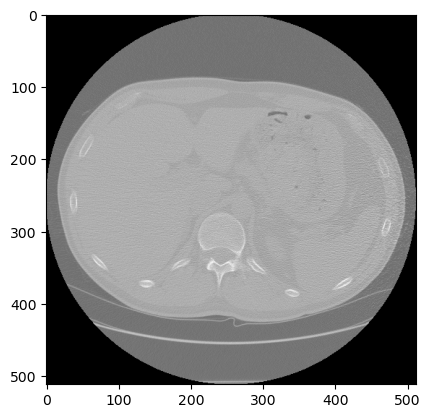

In [81]:
# Read the .mhd file
image = sitk.ReadImage('./data/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd')

# Convert the image to a numpy array
image_array = sitk.GetArrayFromImage(image)

# Display an image slice
plt.imshow(image_array[0], cmap='gray')
plt.show()

In [84]:
import os
root = os.path.join(os.getcwd(),"./data/luna16/subset0/subset0")
paths = os.listdir(root)
print(paths)

['1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.1261214600172571370987811435

In [85]:
for path in paths:
    if path.find('mhd')>=0:
        data =sitk.ReadImage(os.path.join(root,path))
        #print(data)

#### Following code defines a function `plot_ct_scan` that plots a series of CT scan slices

In [86]:
def plot_ct_scan(scan, num_column=4, jump=1):
    num_slices = len(scan)
    num_row = (num_slices//jump + num_column - 1) // num_column
    f, plots = plt.subplots(num_row, num_column, figsize=(num_column*5, num_row*5))
    for i in range(0, num_row*num_column):
        plot = plots[i % num_column] if num_row == 1 else plots[i // num_column, i % num_column]        
        plot.axis('off')
        if i < num_slices//jump:
            plot.imshow(scan[i*jump], cmap=plt.cm.bone) 

In [87]:
    %matplotlib inline   
    spacing = data.GetSpacing()
    scan = sitk.GetArrayFromImage(data)
    print('spacing: ', spacing)
    print('# slice: ', len(scan))

spacing:  (0.6640620231628418, 0.6640620231628418, 2.0)
# slice:  140


### Code block below performs the following operations:

1. It defines a function `extract_main(mask, spacing, vol_limit=[0.68, 8.2])` that extracts the main region of interest from a binary mask based on volume limits.

2. The function calculates the voxel volume based on the voxel spacing.

3. It applies connected-component labeling to the mask and computes region properties using the `skimage.measure.label` and `skimage.measure.regionprops` functions.

4. The function iterates over the identified regions and checks if their volumes fall outside the specified volume limits. Regions outside the limits are set to 0 in the mask.

5. The modified mask is returned by the function.

6. The code further updates the mask and the corresponding elements in the `scan` image using the `extract_main` function, removing regions outside the desired mask.

7. Finally, the modified `scan` image is visualized using the `plot_ct_scan` function.

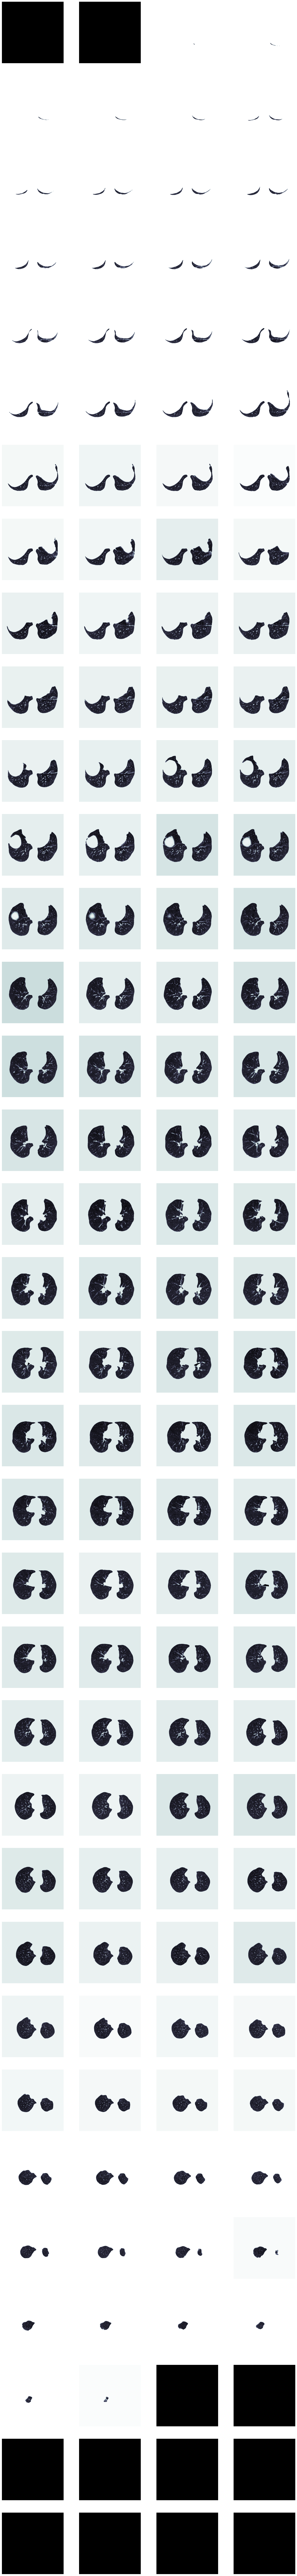

In [90]:
from skimage import measure
def extract_main(mask, spacing, vol_limit=[0.68, 8.2]):
    
    voxel_vol = spacing[0]*spacing[1]*spacing[2]

    label = measure.label(mask, connectivity=1)

    properties = measure.regionprops(label)

    for prop in properties:
            if prop.area * voxel_vol < vol_limit[0] * 1e6 or prop.area * voxel_vol > vol_limit[1] * 1e6:
                mask[label == prop.label] = 0
                
    return mask

mask = extract_main(mask, spacing)
scan[~mask] = 0
plot_ct_scan(scan, jump=1)

### Let's try and create a 3D representation of lung from CT scans:

#### Code block below performs the following operations:

1. The code defines a function `plot_3d(image, threshold = 0)` to visualize a three-dimensional image.

2. The function rearranges the image data to position the scan upright, ensuring that the head of the patient is at the top and facing the camera.

3. It uses the `measure.marching_cubes` function to extract the surface mesh of the image at a specified threshold level.

4. A 3D figure is created using `matplotlib.pyplot.figure` with a specified size, and an axis subplot with a 3D projection is added.

5. The surface mesh is represented as a collection of triangles using `mpl_toolkits.mplot3d.art3d.Poly3DCollection`.

6. The face color of the mesh is set, and the mesh is added to the plot.

7. The x, y, and z limits of the plot are set based on the dimensions of the image.

8. The plot is displayed using `matplotlib.pyplot.show()`.

9. The `plot_3d` function is called with the `scan` image as the input, which visualizes the 3D surface mesh of the image.

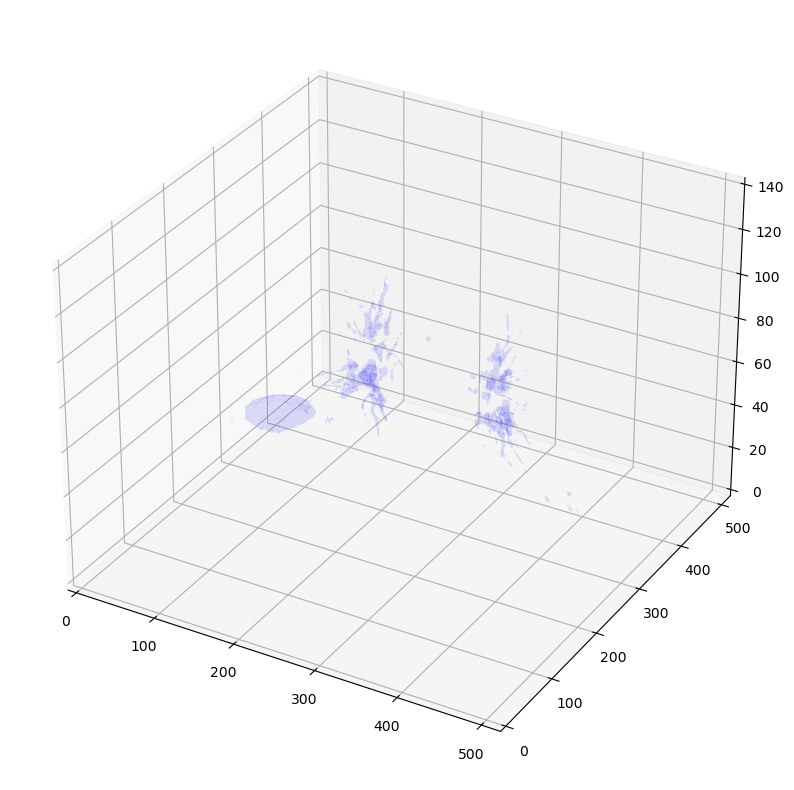

In [94]:
from skimage import measure, feature
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold = 0):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts,faces,_,_ = measure.marching_cubes(p, level=threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

plot_3d(scan)

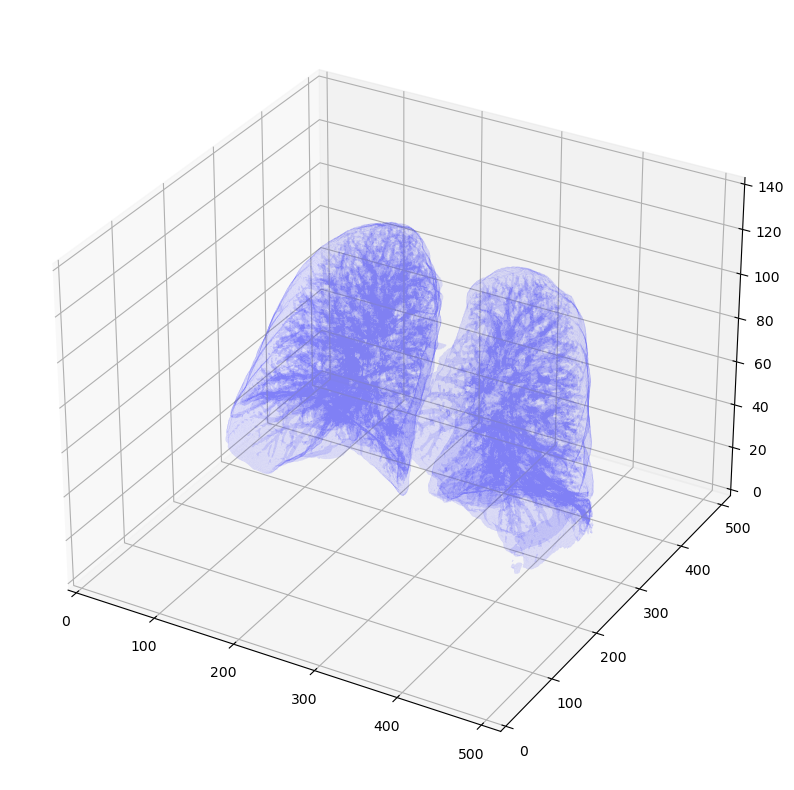

In [95]:
def plot_3d(image, threshold = -700):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p, level=threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
plot_3d(scan)

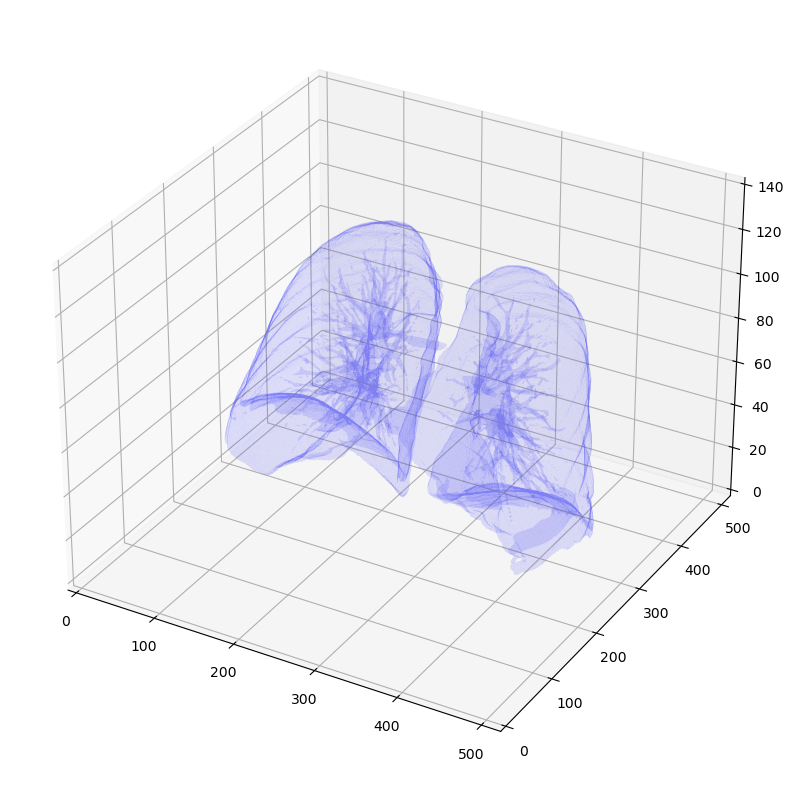

In [97]:
def plot_3d(image, threshold = -300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p, level=threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
plot_3d(scan)

In [98]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(30, 30))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

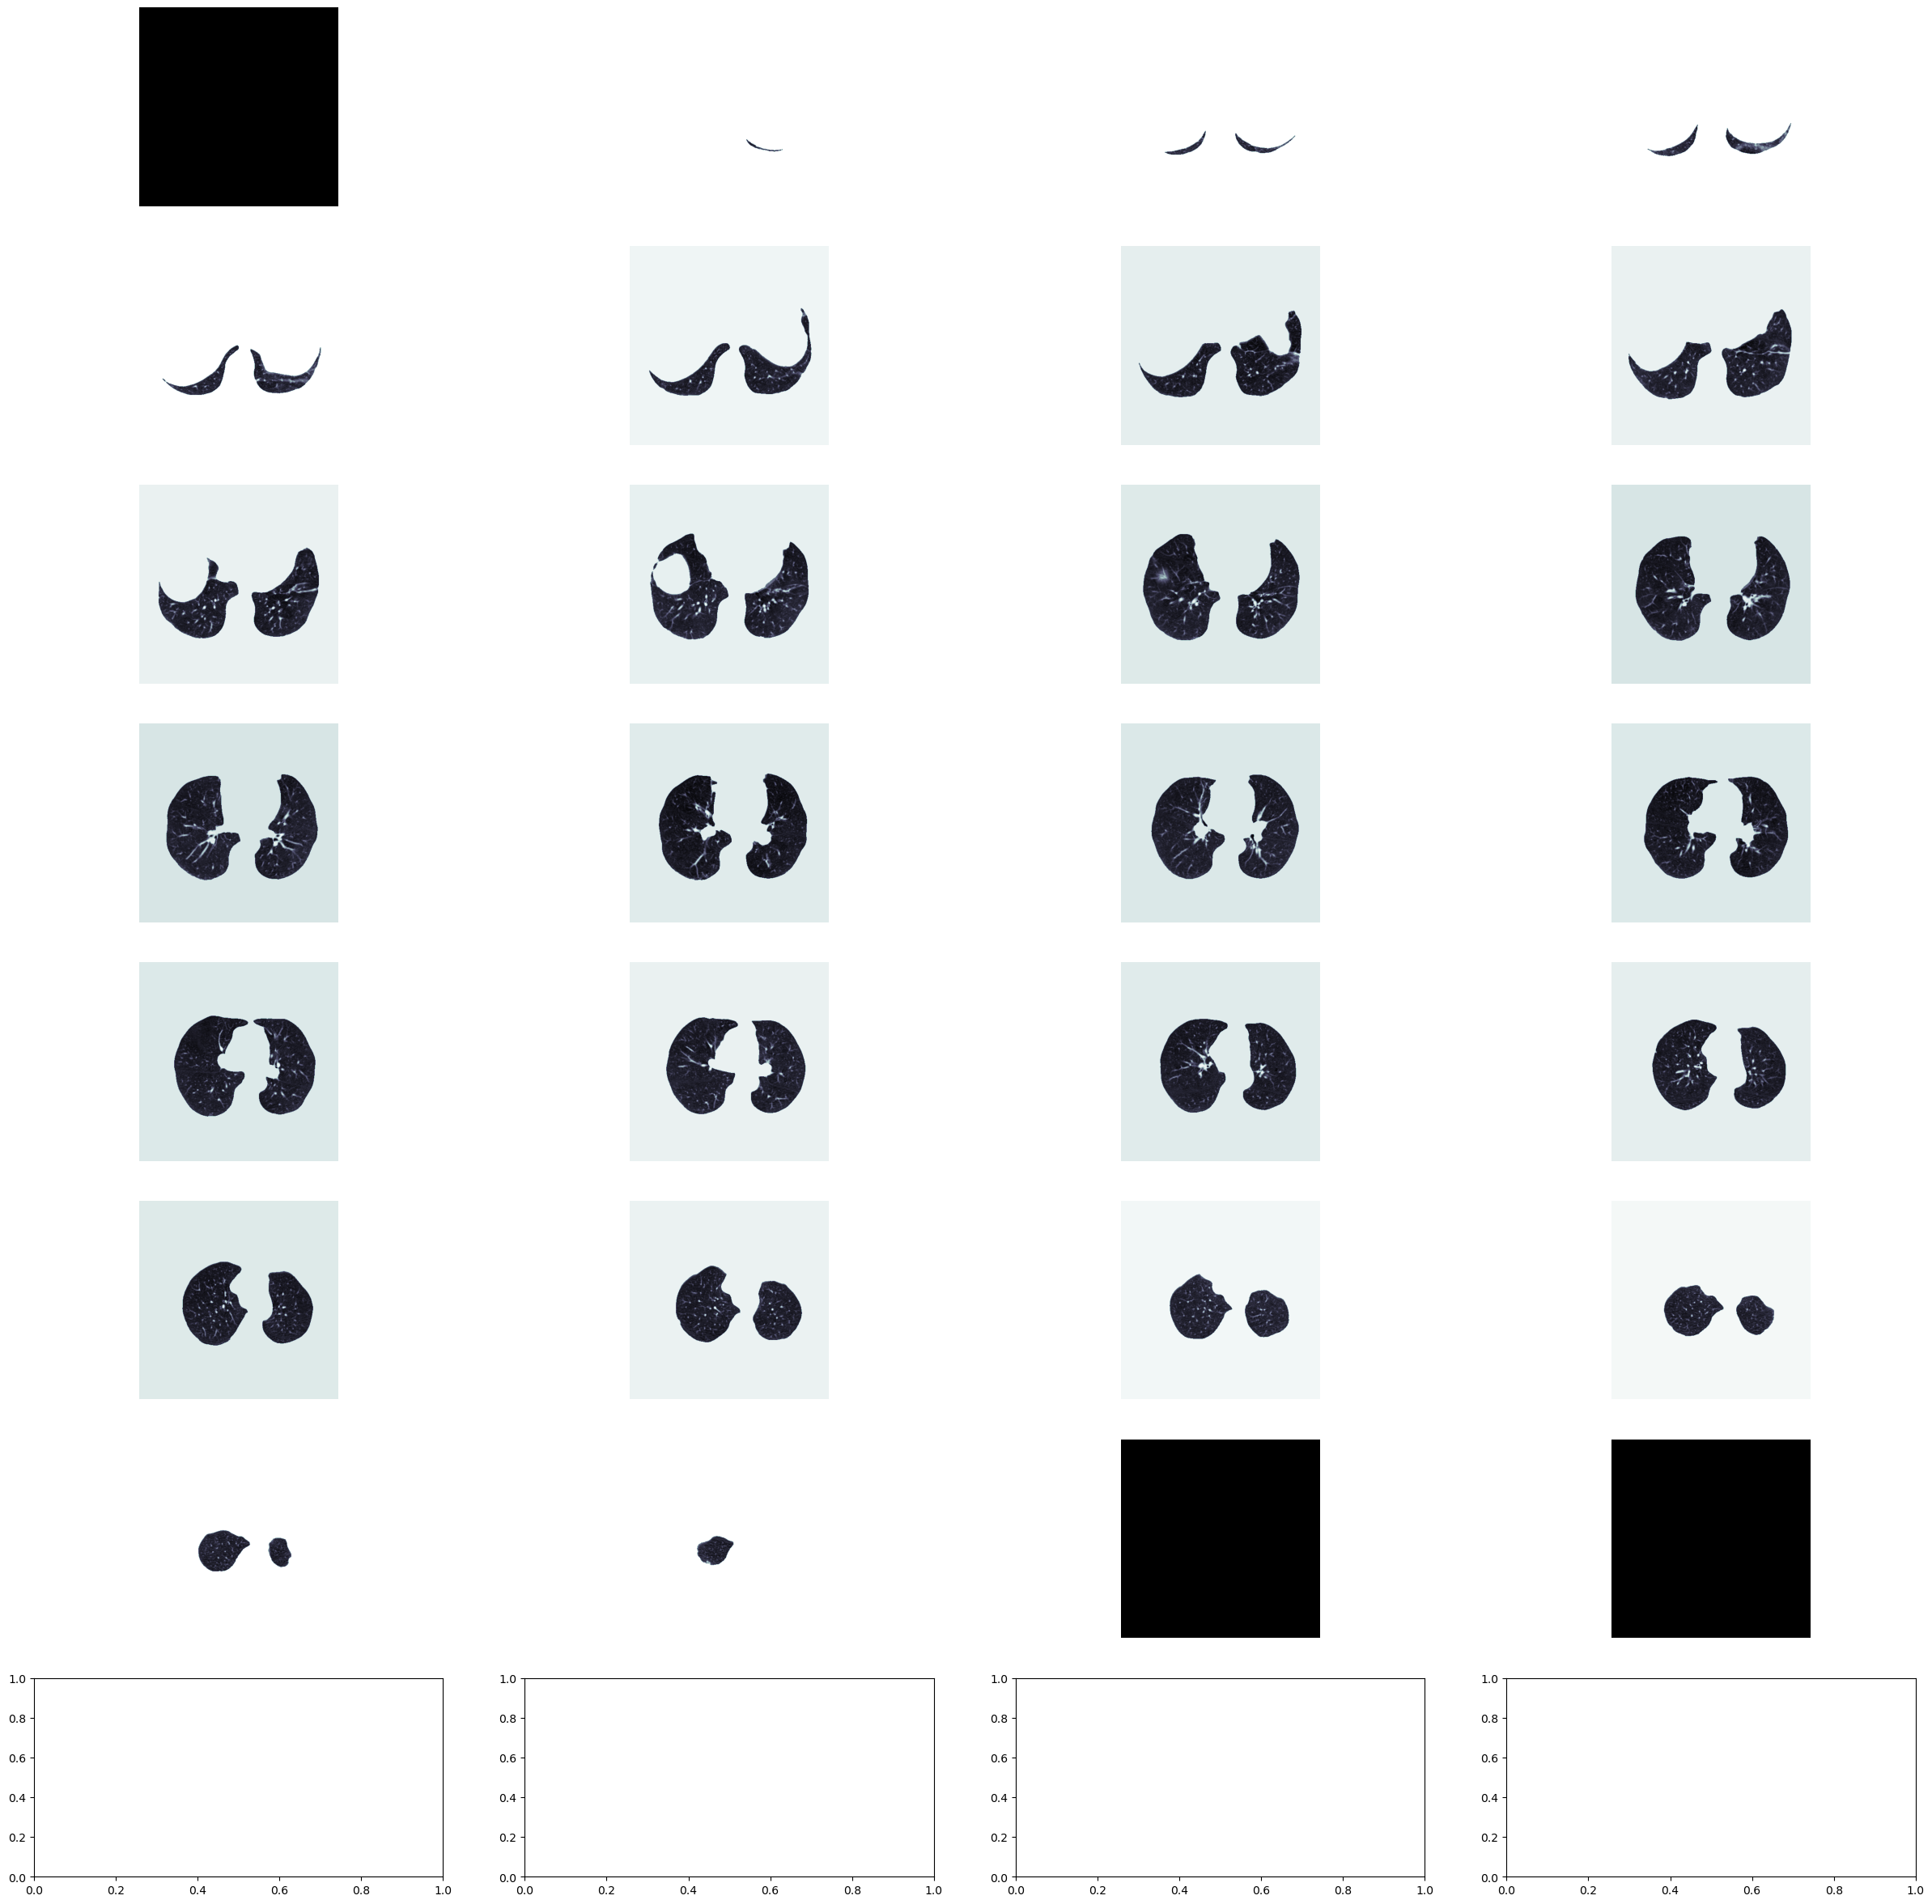

In [99]:
plot_ct_scan(scan)

## Lung Segmentation:

#### Following code defines a function called `get_segmented_lungs`, which is used to segment the lungs from a given 2D slice image. Here is a step-by-step summary of what the code does:

1. The function receives a 2D image slice as input and an optional `plot` parameter for visualization.

2. The code converts the input image into a binary image by thresholding based on a predefined value.

3. It removes blobs or connected components that touch the border of the image to eliminate potential artifacts.

4. The labeled image is obtained by assigning a unique label to each connected region in the binary image.

5. Only the two largest labeled regions (assumed to correspond to the lungs) based on their areas are kept. Smaller labeled regions are discarded.

6. The binary image is updated to include only the lung regions after removing smaller regions.

7. An erosion operation is applied to separate lung nodules attached to blood vessels.

8. A closure operation is performed to keep nodules attached to the lung wall.

9. Small holes inside the binary mask of the lungs are filled.

10. The binary mask is superimposed on the input image by setting corresponding non-lung pixels to zero intensity.

11. If the `plot` parameter is set to `True`, intermediate results are visualized in separate subplots.

12. The resulting segmented lungs are returned as an image.

In [104]:
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
import numpy as np


def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5,40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < -400
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

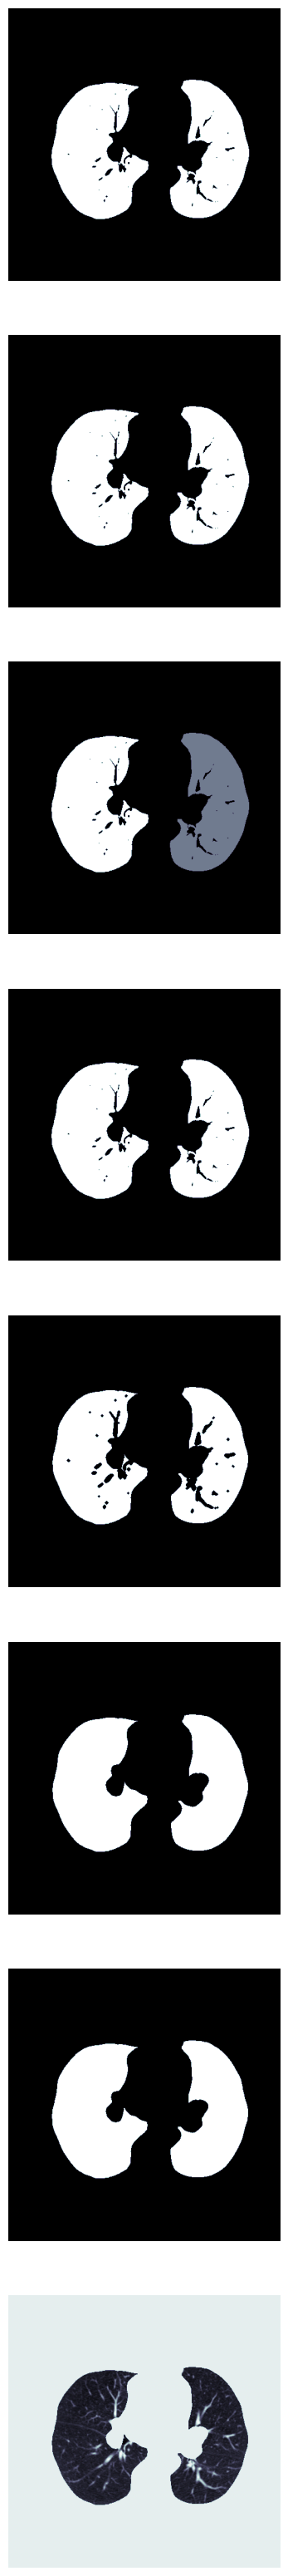

In [105]:
get_segmented_lungs(scan[71], True)

**Following code generates marker images for the watershed segmentation algorithm. It creates an internal marker by thresholding the input image and removes artifacts near the image borders. It generates an external marker by dilating the internal marker, and then computes the watershed marker matrix by combining the internal and external markers. These markers can be used as inputs for watershed segmentation to segment objects of interest in the image.**

Internal Marker


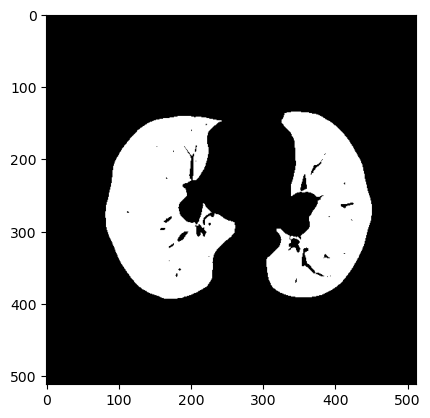

External Marker


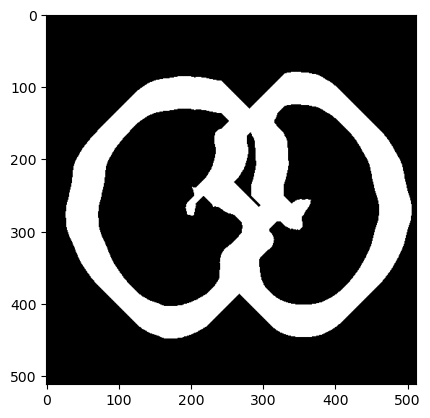

Watershed Marker


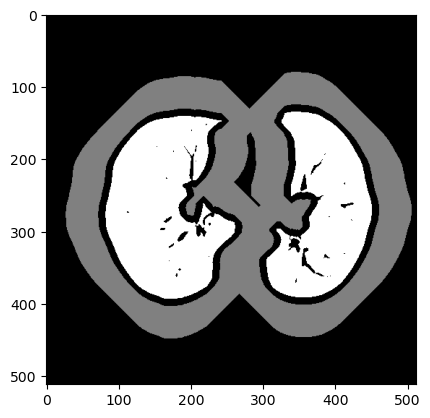

In [109]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(scan[71])
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

**Code below performs lung segmentation by utilizing markers, applying the watershed algorithm on the Sobel gradient image, and refining the segmentation through morphological operations. It generates intermediate images that highlight the lung boundaries and finally provides the segmented lung image.**

Sobel Gradient


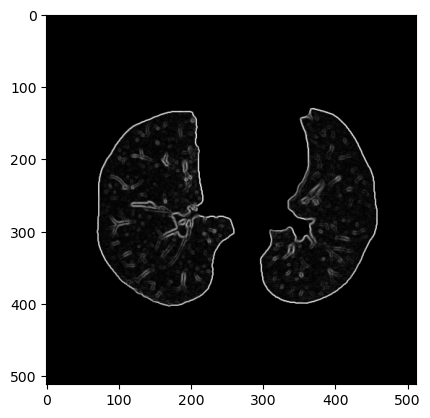

Watershed Image


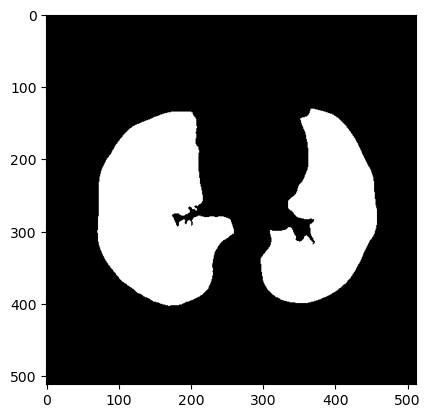

Outline after reinclusion


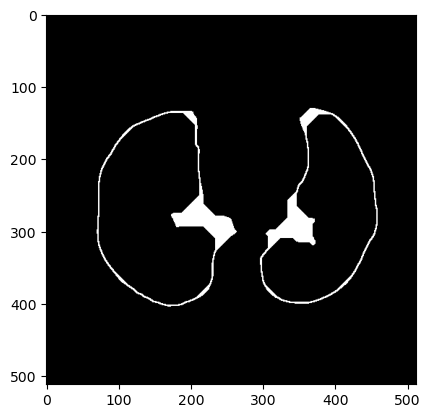

Lungfilter after closing


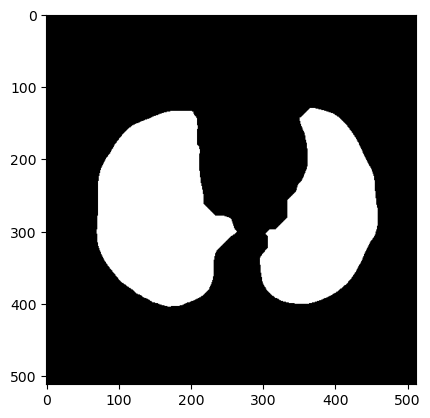

Segmented Lung


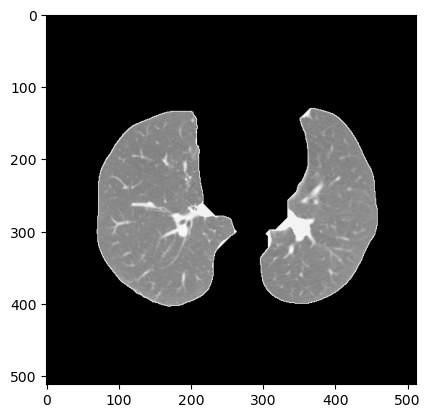

In [114]:
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = segmentation.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

#Some Testcode:
test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(scan[61])


print ("Sobel Gradient")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(test_segmented, cmap='gray')
plt.show()

In [115]:
def segment_lung_from_ct_scan(scan):
    return np.asarray([get_segmented_lungs(slice) for slice in scan])

### Final Segmentation results:

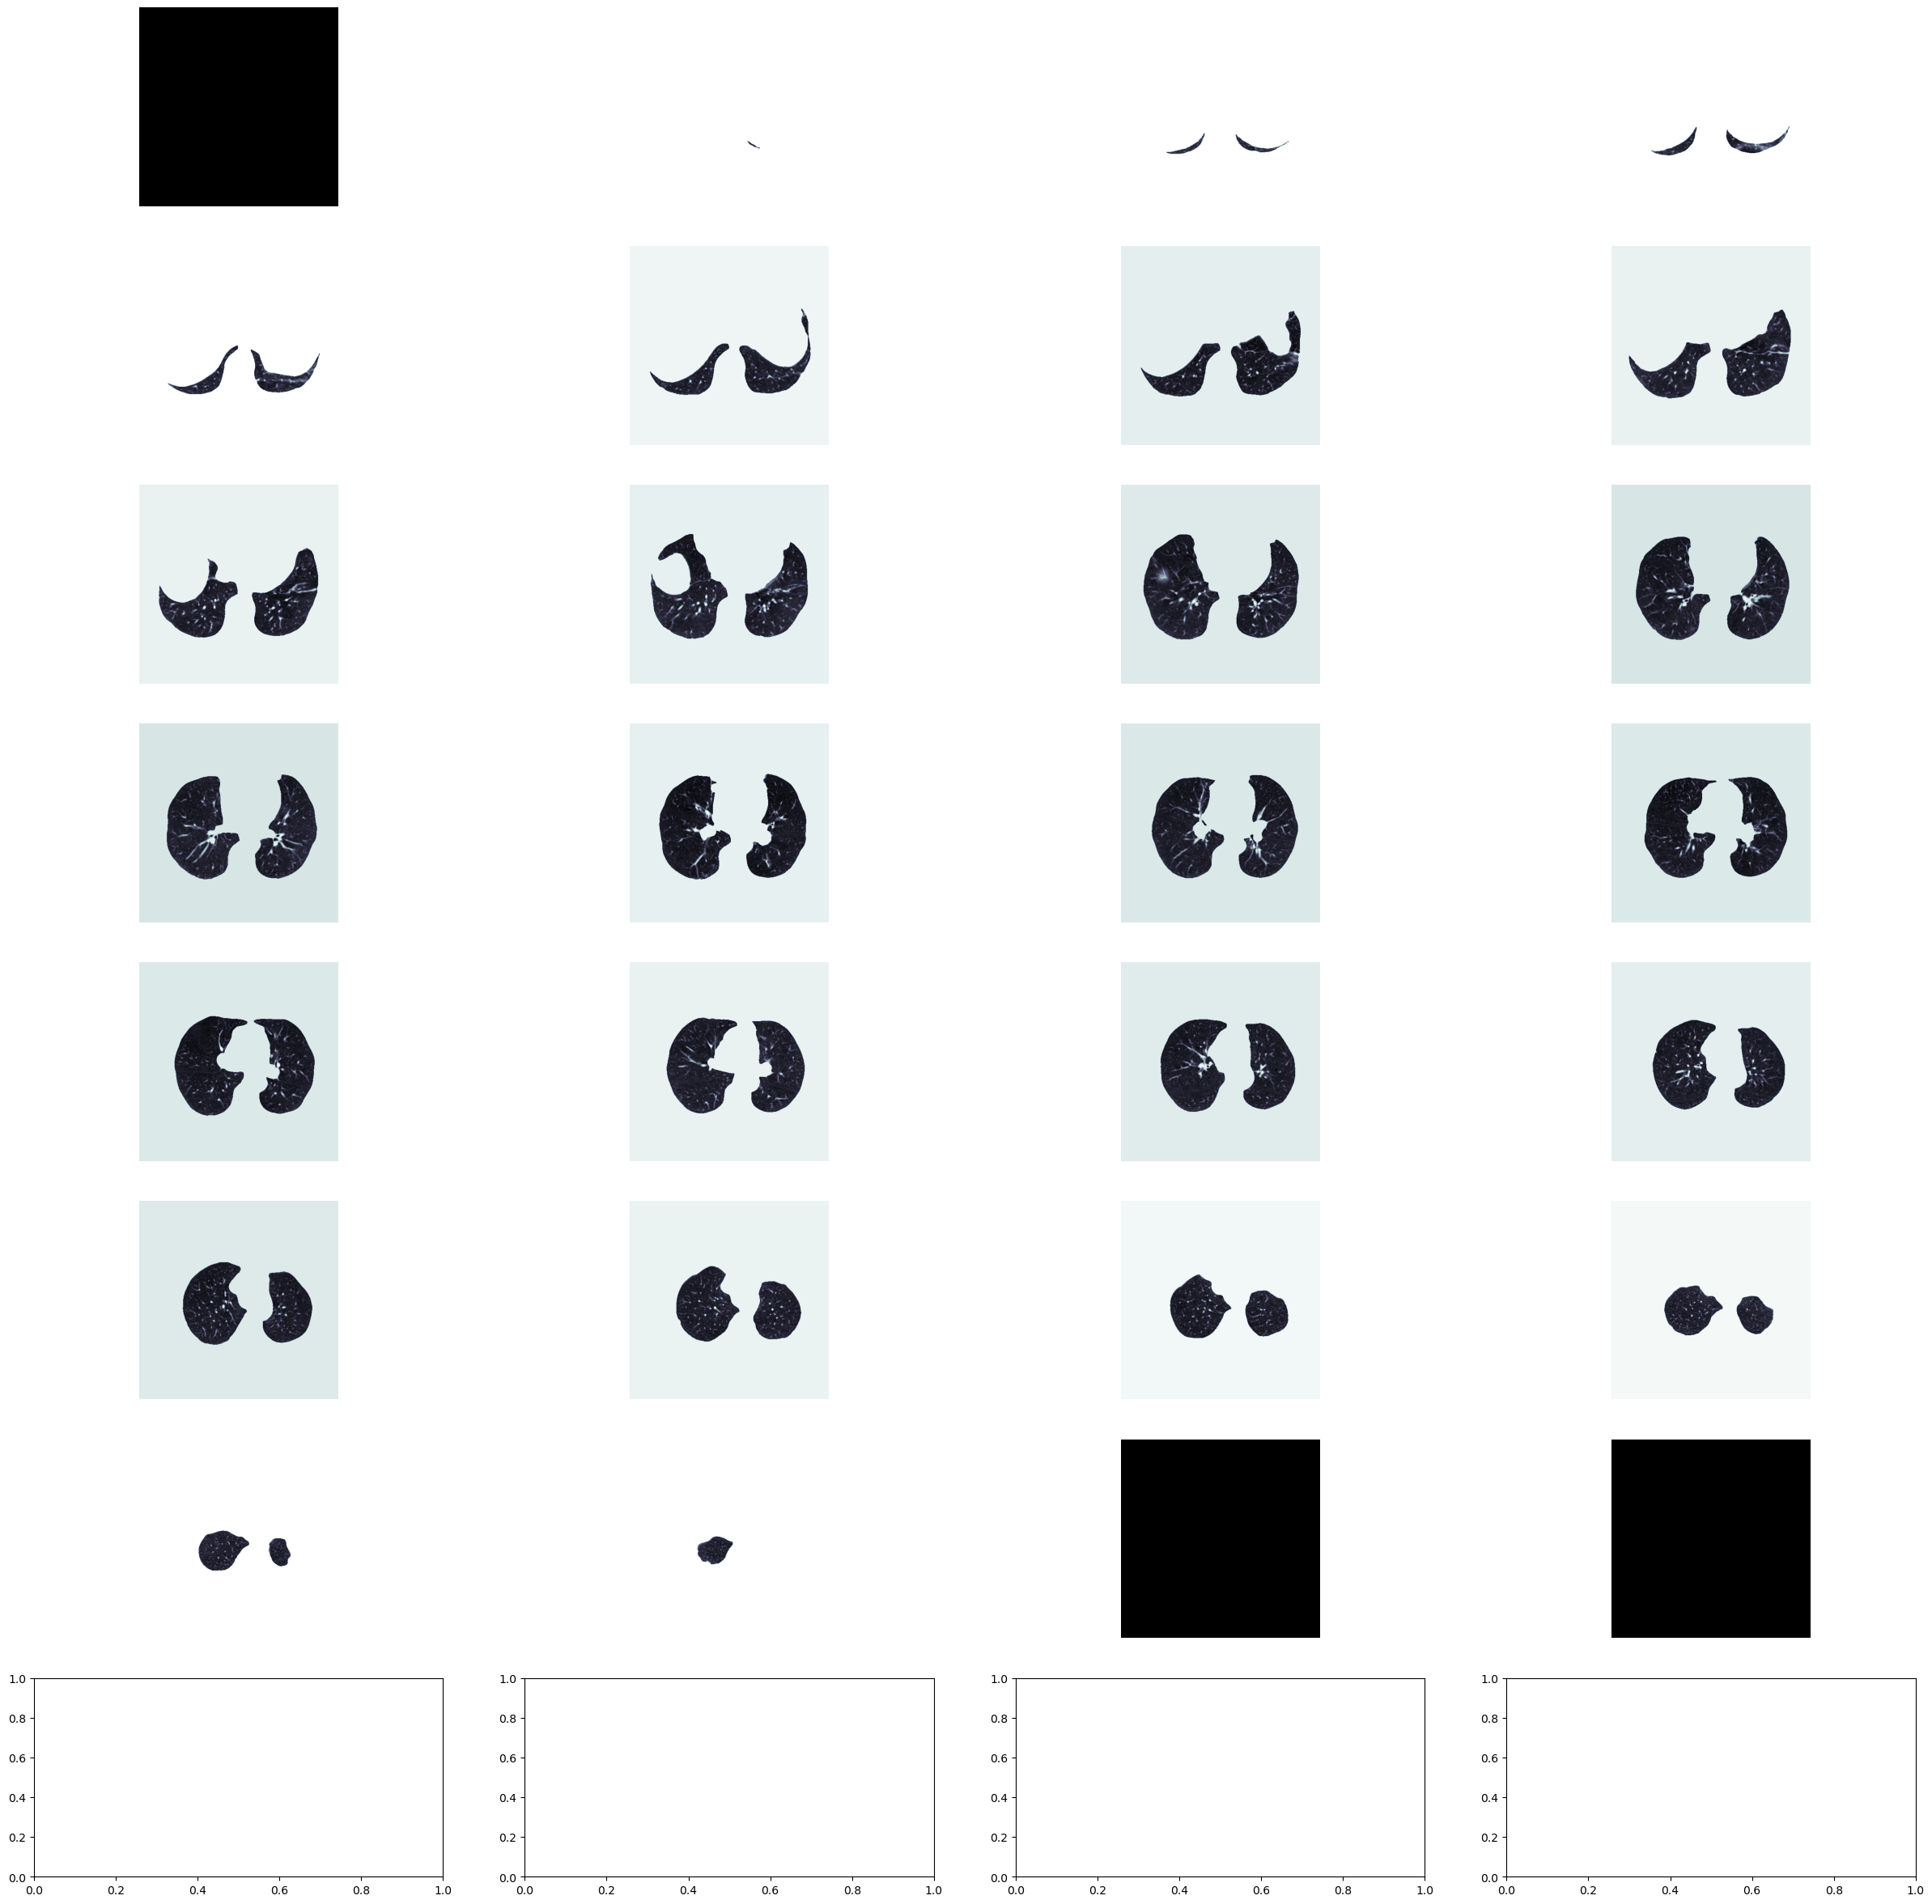

In [116]:
segmented_ct_scan = segment_lung_from_ct_scan(scan)
plot_ct_scan(segmented_ct_scan)